### Підготовка середовища

In [3]:
%pip install opencv-python scikit-image scikit-learn pandas tensorflow keras tqdm

  Obtaining dependency information for tqdm from https://files.pythonhosted.org/packages/2b/78/57043611a16c655c8350b4c01b8d6abfb38cc2acb475238b62c2146186d7/tqdm-4.67.0-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ------------- ------------------------ 20.5/57.6 kB 330.3 kB/s eta 0:00:01
     -------------------------------------- 57.6/57.6 kB 504.1 kB/s eta 0:00:00
   ---------------------------------------- 0.0/78.6 kB ? eta -:--:--
   ------------------------------------ --- 71.7/78.6 kB 2.0 MB/s eta 0:00:01
   ---------------------------------------- 78.6/78.6 kB 1.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


#### Імпорт бібліотек

In [13]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

**DataLeakage** 
1. Аналіз даних
Витоки: 
- Скоріше за все датасет збирали різні люди, так як формати і дані досить сильно можуть відрізнятись (як результат потрібно окремо просіювати датасет) (в нашому випадку робимо ми це вручну, переглядаючи картинки)
- Забрудення даних (точно виявлено картинка для класу, яка взагалі не відноситься до теми + є картинки з текстом, це не ок) 
- Чи є дублікати? (перевіряємо на дублікати зображення, щоб не було так, що ніби різні картинки (хоча вони ідентичні) потрапили в різні вибірки)

Глобальні налаштування

In [2]:
dataset_path = 'data/house_plant_species'

img_height = 180
img_width = 180
batch_size = 32

Огляд всіх можливих класів

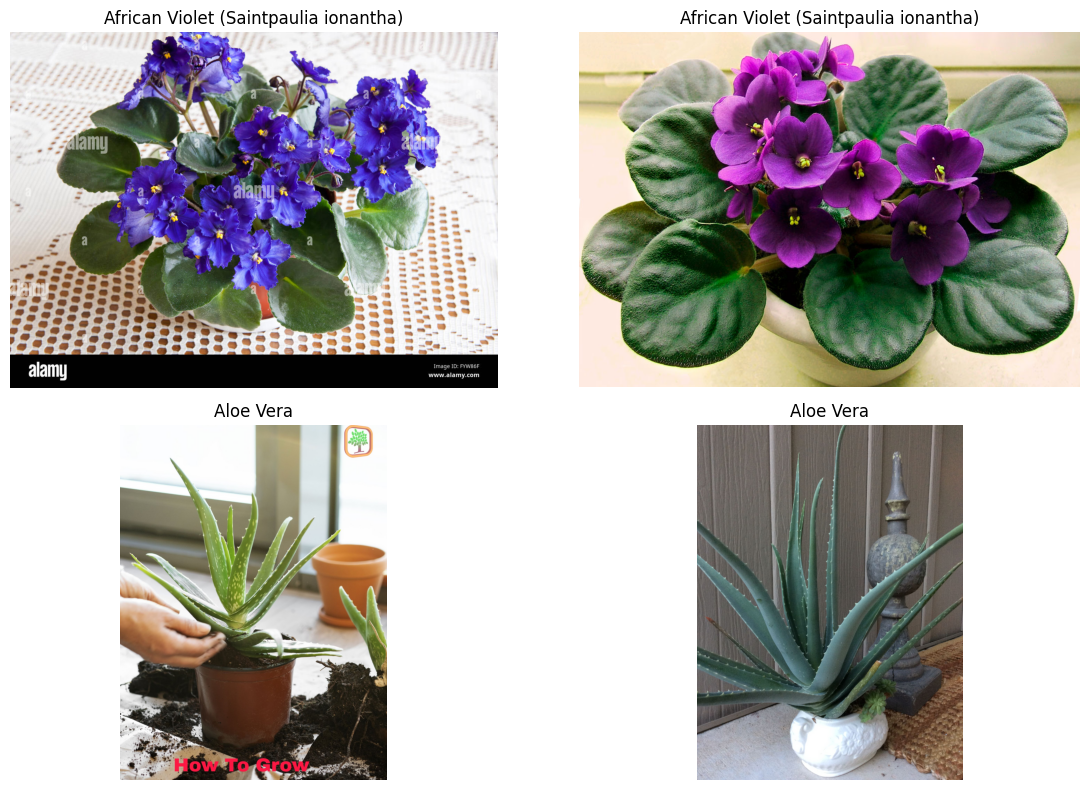

In [34]:
classes = os.listdir(dataset_path)

num_images_per_class = 2
num_classes = len(classes)

plt.figure(figsize=(12, num_classes * 4))

for i, class_name in enumerate(classes):
    class_folder = os.path.join(dataset_path, class_name)
    images = os.listdir(class_folder)

    
    for j in range(min(num_images_per_class, len(images))):
        img_path = os.path.join(class_folder, images[j])
        img = Image.open(img_path)

        plt.subplot(num_classes, num_images_per_class, i * num_images_per_class + j + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(class_name)

plt.tight_layout()
plt.show()

Код для реалізації перевірки дублікатів шляхом хешування або коефіцієнта подібності

In [4]:
import os
import hashlib
import numpy as np
import cv2
from PIL import Image
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed

class ImageDuplicateFinder:
    def __init__(self, threshold=0.95):
        """
        Ініціалізація класу для пошуку дублікатів зображень
        
        :param threshold: поріг подібності зображень (0-1)
        """
        self.threshold = threshold
    
    def _hash_image(self, image_path):
        """
        Генерація хешу зображення
        
        :param image_path: шлях до зображення
        :return: хеш зображення
        """
        try:
            with open(image_path, 'rb') as f:
                return hashlib.md5(f.read()).hexdigest()
        except Exception:
            return None
    
    def _perceptual_hash(self, image_path, hash_size=8):
        """
        Перцептивний хеш зображення
        
        :param image_path: шлях до зображення
        :param hash_size: розмір хешу
        :return: перцептивний хеш
        """
        try:
            # Завантаження зображення
            img = Image.open(image_path).convert('L')
            
            # Зміна розміру
            img = img.resize((hash_size + 1, hash_size + 1), Image.LANCZOS)
            
            # Конвертація в numpy
            pixels = np.array(img)
            
            # Обчислення середнього значення
            avg = pixels.mean()
            
            # Генерація хешу
            diff = pixels > avg
            return sum([2**i for (i, v) in enumerate(diff.flatten()) if v])
        
        except Exception:
            return None
    
    def _compare_images(self, image1_path, image2_path):
        """
        Порівняння двох зображень
        
        :param image1_path: шлях до першого зображення
        :param image2_path: шлях до другого зображення
        :return: коефіцієнт подібності
        """
        try:
            # Завантаження зображень
            img1 = cv2.imread(image1_path)
            img2 = cv2.imread(image2_path)
            
            # Зміна розміру
            img1 = cv2.resize(img1, (256, 256))
            img2 = cv2.resize(img2, (256, 256))
            
            # Перетворення в сірі
            gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
            gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
            
            # Обчислення структурної подібності
            similarity = cv2.compareSSIM(gray1, gray2)
            
            return similarity
        
        except Exception:
            return 0
    
    def find_duplicates(self, directory, method='hash'):
        """
        Пошук дублікатів зображень
        
        :param directory: директорія з зображеннями
        :param method: метод пошуку дублікатів ('hash', 'perceptual', 'compare')
        :return: словник дублікатів
        """
        # Підтримувані розширення
        image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']
        
        # Список зображень
        image_paths = []
        for root, _, files in os.walk(directory):
            for file in files:
                if os.path.splitext(file)[1].lower() in image_extensions:
                    image_paths.append(os.path.join(root, file))
        
        # Словник для зберігання дублікатів
        duplicates = {}
        
        # Обрання методу
        if method == 'hash':
            compare_func = self._hash_image
        elif method == 'perceptual':
            compare_func = self._perceptual_hash
        else:
            compare_func = self._compare_images
        
        # Паралельне обчислення
        with ProcessPoolExecutor() as executor:
            # Словник для зберігання хешів
            hashes = {}
            
            # Обчислення хешів
            futures = {
                executor.submit(compare_func, path): path 
                for path in image_paths
            }
            
            # Прогрес бар
            for future in tqdm(as_completed(futures), total=len(futures)):
                path = futures[future]
                try:
                    hash_value = future.result()
                    
                    # Накопичення дублікатів
                    if hash_value in hashes:
                        if path not in duplicates:
                            duplicates[path] = []
                        duplicates[path].append(hashes[hash_value])
                    else:
                        hashes[hash_value] = path
                
                except Exception:
                    pass
        
        return duplicates
    
    def remove_duplicates(self, duplicates, keep_first=True):
        """
        Видалення дублікатів
        
        :param duplicates: словник дублікатів
        :param keep_first: залишати перше зображення
        """
        for original, duplicate_list in duplicates.items():
            for duplicate in duplicate_list:
                try:
                    # Видалення файлу
                    os.remove(duplicate)
                    print(f"Видалено дублікат: {duplicate}")
                except Exception as e:
                    print(f"Помилка видалення {duplicate}: {e}")

Шукаємо дублікати (як бачимо знизу, дублікатів не виявлено, отже про один можливий витік можна забути (для цих даних))

In [6]:
duplicate_finder = ImageDuplicateFinder(threshold=0.95)
    
duplicates = duplicate_finder.find_duplicates(
        directory='data/final_data', 
        method='hash'
    )
    
for original, duplicate_list in duplicates.items():
    print(f"Оригінал: {original}")
    print("Дублікати:")
    for duplicate in duplicate_list:
        print(f" - {duplicate}")

100%|██████████| 582/582 [00:00<00:00, 3457.65it/s]


In [ ]:

duplicate_finder.remove_duplicates(duplicates) # Видаляємо, якщо знайдемо дублікати

**DataLeakage** 

Переходимо до розбиття даних:
1. Якщо по правильному розбиття має відбувати не рандомно, а враховуючи структуру даних + ми маємо розділяти дані на тренувальну, тестову, валідаційну вибірки до них мають потрапити абсолютно різні фото (у нашому випадку), потрібно виключити попадання схожих зображень до різних наборів. Це ми можемо зробити шляхом ручного розбиття, так щоб наприклад ті що вже входять у вибірку валідаційну або текстову зі 100% не могли потрапити в тренувальну. В нашому випадку написали функцію split_dataset для цього.

2. Нормалізація має відбуватись по кожному наборі, тобто для тренувальних, тестових, валідаційних даних окремо! (в даному випадку нормалізація буде завжди однокова, мінімальний та максимальний піксель 1-255, більше чи менше просто бути не може) (але це тільки для зображень)

3. Для виключення помилок в коді і просто проблем саме з точки зору програміста-аналітика, обов'язково вводимо pipeline!

  Розподіл датасету на train/val/test з унеможливленням перетину даних

In [ ]:
import os
import shutil
import random

def split_dataset(
    source_dir, 
    output_dir, 
    train_ratio=0.7, 
    val_ratio=0.15, 
    test_ratio=0.15, 
    random_seed=42
):
    """
    Розподіл датасету на train/val/test з унеможливленням перетину даних
    
    :param source_dir: шлях до вихідної директорії з класами
    :param output_dir: шлях до нової директорії для розподіленого датасету
    :param train_ratio: частка тренувальних даних
    :param val_ratio: частка валідаційних даних
    :param test_ratio: частка тестових даних
    :param random_seed: seed для відтворюваності
    """
    # Встановлення seed для відтворюваності
    random.seed(random_seed)
    
    # Перевірка коректності вхідних параметрів
    if abs(train_ratio + val_ratio + test_ratio - 1.0) > 1e-10:
        raise ValueError("Суми часток мають дорівнювати 1.0")
    
    # Створення директорій для нового датасету
    os.makedirs(output_dir, exist_ok=True)
    train_dir = os.path.join(output_dir, 'train')
    val_dir = os.path.join(output_dir, 'validation')
    test_dir = os.path.join(output_dir, 'test')
    
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    
    # Обхід класів у вихідній директорії
    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        
        # Пропускаємо не директорії
        if not os.path.isdir(class_path):
            continue
        
        # Створення директорій для класів у новій структурі
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)
        
        # Отримання списку файлів
        files = os.listdir(class_path)
        
        # Перемішування файлів
        random.shuffle(files)
        
        # Розрахунок кількості файлів для кожної вибірки
        total_files = len(files)
        train_count = int(total_files * train_ratio)
        val_count = int(total_files * val_ratio)
        test_count = total_files - train_count - val_count
        
        # Розподіл файлів
        train_files = files[:train_count]
        val_files = files[train_count:train_count+val_count]
        test_files = files[train_count+val_count:]
        
        # Переміщення файлів
        for file_list, dest_dir in [
            (train_files, os.path.join(train_dir, class_name)),
            (val_files, os.path.join(val_dir, class_name)),
            (test_files, os.path.join(test_dir, class_name))
        ]:
            for filename in file_list:
                src_path = os.path.join(class_path, filename)
                dst_path = os.path.join(dest_dir, filename)
                shutil.move(src_path, dst_path)
        
        # Видалення порожніх директорій класів
        if not os.listdir(class_path):
            os.rmdir(class_path)
    
    # Видалення порожньої вихідної директорії
    if not os.listdir(source_dir):
        os.rmdir(source_dir)
    
    print(f"Датасет розподілено в {output_dir}")

Датасет розподілено в data/final_data


In [ ]:
split_dataset(
    source_dir='data/house_plant_species',           
    output_dir='data/final_data',       
    train_ratio=0.7,           
    val_ratio=0.15,              
    test_ratio=0.15              
)

In [ ]:
train_data_path = "data/final_data/train"
validationn_data_path = "data/final_data/validation"
test_data_path = "data/final_data/test"

# для кожного набору даних, вводимо свій генератор для окремої нормалізації
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

Застосовуємо генератори з окремою нормалізацією та даними, які не перетинаються

In [7]:
train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
)

validation_generator = valid_datagen.flow_from_directory(
    validationn_data_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
)

test_generator = test_datagen.flow_from_directory(
    test_data_path,  
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 405 images belonging to 2 classes.
Found 86 images belonging to 2 classes.
Found 91 images belonging to 2 classes.


In [ ]:
# Кількість класів, яка нам потрібна
num_classes = 2

Створення моделі та її компіляція

In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

d:\Labs\BigData\venvGlobal\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Навчання моделі

In [11]:
epochs = 8
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs
)

Epoch 1/8


d:\Labs\BigData\venvGlobal\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5601 - loss: 1.4763 - val_accuracy: 0.9062 - val_loss: 0.3258
Epoch 2/8
 1/12 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7188 - loss: 0.4497

C:\Users\Klevendor\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7188 - loss: 0.4497 - val_accuracy: 0.8182 - val_loss: 0.4181
Epoch 3/8
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8544 - loss: 0.3461 - val_accuracy: 0.9062 - val_loss: 0.2454
Epoch 4/8
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8750 - loss: 0.2249 - val_accuracy: 0.9545 - val_loss: 0.0894
Epoch 5/8
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9511 - loss: 0.1323 - val_accuracy: 0.9531 - val_loss: 0.1713
Epoch 6/8
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9688 - loss: 0.0592 - val_accuracy: 0.9091 - val_loss: 0.3471
Epoch 7/8
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9670 - loss: 0.1017 - val_accuracy: 0.9375 - val_loss: 0.2204
Epoch 8/8
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9375 - loss: 0.1227 - val_accuracy: 1.0000 - val_loss: 0.0250


Тестування на тестових даних (ці дані модель, ще ніколи не бачила)

In [12]:
loss, accuracy = model.evaluate(test_generator)
print(f"Тестова точність (дані, які модель ще не бачила): {accuracy}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 566ms/step - accuracy: 0.9656 - loss: 0.1282
Тестова точність (дані, які модель ще не бачила): 0.9780219793319702


**DataLeakage** 

Ще варіанти витоку:
1. Датасет не має містити службової інформації та метаданих (в ношому випадку OK)

2. Щодо ознак в даному випадку пікселі без інших даних, тому потрапити дані з цільовї змінної туда не могли 

Як писалося раніше створюємо pipeline, для мінімізації помилок

In [16]:
class PlantClassificationPipeline:
    def __init__(
        self, 
        img_height=180, 
        img_width=180, 
        batch_size=180, 
        num_classes=2
    ):
        # Параметри
        self.img_height = img_height
        self.img_width = img_width
        self.batch_size = batch_size
        self.num_classes = num_classes
        
        # Шляхи до даних
        self.train_data_path = "data/final_data/train"
        self.validation_data_path = "data/final_data/validation"
        self.test_data_path = "data/final_data/test"
        
        # Підготовка генераторів даних
        self._prepare_data_generators()
        
        # Створення моделі
        self.model = self._build_model()
        
    def _prepare_data_generators(self):
        """Підготовка генераторів для train, validation, test"""
        # Аугментація та нормалізація
        train_datagen = ImageDataGenerator(rescale=1./255)
        test_datagen = ImageDataGenerator(rescale=1./255)
        valid_datagen = ImageDataGenerator(rescale=1./255)
        
        # Генератори
        self.train_generator = train_datagen.flow_from_directory(
            train_data_path,
            target_size=(img_height, img_width),
            batch_size=batch_size,
            class_mode='categorical',
        )

        self.validation_generator = valid_datagen.flow_from_directory(
            validationn_data_path,
            target_size=(img_height, img_width),
            batch_size=batch_size,
            class_mode='categorical',
        )

        self.test_generator = test_datagen.flow_from_directory(
            test_data_path,  
            target_size=(img_height, img_width),
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=False
        )
                
    def _build_model(self):
        """Створення архітектури нейронної мережі"""
        model = models.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', 
                          input_shape=(self.img_height, self.img_width, 3)),
            layers.MaxPooling2D(),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.MaxPooling2D(),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.5),  # Додано дропаут
            layers.Dense(self.num_classes, activation='softmax')
        ])
        
        # Компіляція моделі
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model
    
    def _get_callbacks(self):
        """Створення колбеків"""
        early_stopping = EarlyStopping(
            monitor='val_loss', 
            patience=5, 
            restore_best_weights=True
        )
        
        model_checkpoint = ModelCheckpoint(
            'best_model.keras', 
            monitor='val_accuracy', 
            save_best_only=True
        )
        
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.2, 
            patience=3, 
            min_lr=0.00001
        )
        
        return [early_stopping, model_checkpoint, reduce_lr]
    
    def train(self, epochs=10):
        """Тренування моделі"""
        history = self.model.fit(
            self.train_generator,
            steps_per_epoch=self.train_generator.samples // self.batch_size,
            validation_data=self.validation_generator,
            validation_steps=self.validation_generator.samples // self.batch_size,
            epochs=epochs,
            callbacks=self._get_callbacks()
        )
        
        return history
    
    def evaluate(self):
        """Оцінка на тестовому наборі"""
        test_loss, test_accuracy = self.model.evaluate(
            self.test_generator, 
            steps=self.test_generator.samples // self.batch_size
        )
        
        print(f"Test Loss: {test_loss}")
        print(f"Test Accuracy: {test_accuracy}")
        
        return test_loss, test_accuracy
    
    def predict(self, images):
        """Передбачення для нових зображень"""
        predictions = self.model.predict(images)
        return predictions

Використовуємо pipeline

In [ ]:
pipeline = PlantClassificationPipeline(
        img_height=180, 
        img_width=180, 
        batch_size=32, 
        num_classes=2
    )

history = pipeline.train(epochs=8)
    
pipeline.evaluate()

Found 405 images belonging to 2 classes.


Found 86 images belonging to 2 classes.
Found 91 images belonging to 2 classes.
Epoch 1/10


d:\Labs\BigData\venvGlobal\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5677 - loss: 0.7059 - val_accuracy: 0.9219 - val_loss: 0.2781 - learning_rate: 0.0010
Epoch 2/10
 1/12 ━━━━━━━━━━━━━━━━━━━━ 8s 794ms/step - accuracy: 0.8438 - loss: 0.4704

C:\Users\Klevendor\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8438 - loss: 0.4704 - val_accuracy: 0.9545 - val_loss: 0.1379 - learning_rate: 0.0010
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9164 - loss: 0.2460 - val_accuracy: 0.9375 - val_loss: 0.2434 - learning_rate: 0.0010
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9375 - loss: 0.1108 - val_accuracy: 0.9545 - val_loss: 0.1892 - learning_rate: 0.0010
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9483 - loss: 0.1440 - val_accuracy: 0.9531 - val_loss: 0.0885 - learning_rate: 0.0010
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9375 - loss: 0.0898 - val_accuracy: 0.9091 - val_loss: 0.2998 - learning_rate: 0.0010
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9458 - loss: 0.1155 - val_accuracy: 0.9531 - val_loss: 0.1194 - learning_rate: 0.0010
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9688 - loss: 0.0584 - val_accuracy: 0.9091 

(0.05824413150548935, 0.984375)

Раніше точність складала приблизно 0.9780 так як стара версія навчання просто використовувала рандомний розподіл, що теоретично давав можливість потрапити в тестову чи валідаційну вибірку даних. А зараз з врахуванням, цього можливого витоку отримали 0.9843, отже ми в плюсі

### Кінець лаби по DataLeakage

Перетворення датасету в Dataframe і його тестування на простих моделях

In [9]:
import os
import pandas as pd
from PIL import Image
import numpy as np

In [10]:
def load_and_preprocess_image(img_path, target_size=(32, 32)):
    try:
        # Відкриття зображення з явним перетворенням у RGB
        with Image.open(img_path) as img:
            img = img.convert('RGB')  # Явне перетворення у RGB
            img = img.resize(target_size, Image.LANCZOS)  # Висока якість ресайзу
            return np.array(img).flatten()
    except Exception as e:
        print(f"Помилка обробки зображення {img_path}: {e}")
        return None

In [11]:
dataset_path = 'data/house_plant_species'

data = []
labels = []

for class_name in os.listdir(dataset_path):
    class_folder = os.path.join(dataset_path, class_name)
    
    if os.path.isdir(class_folder):
        for image_name in os.listdir(class_folder):
            img_path = os.path.join(class_folder, image_name)
            
            # Перевірка розширення файлу
            if image_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                processed_image = load_and_preprocess_image(img_path)
                
                if processed_image is not None:
                    # Додавання масиву зображення та мітки класу
                    data.append(list(processed_image))
                    labels.append(class_name)

In [12]:
pixel_columns = [f'pixel_{i}' for i in range(len(data[0]))]
df = pd.DataFrame(data, columns=pixel_columns)
df['class_name'] = labels

print("Форма DataFrame:", df.shape)
print("Унікальні класи:", df['class_name'].unique())
print("Перші 5 рядків:\n", df.head())

Форма DataFrame: (582, 3073)
Унікальні класи: ['African Violet (Saintpaulia ionantha)' 'Aloe Vera']
Перші 5 рядків:
    pixel_0  pixel_1  pixel_2  pixel_3  pixel_4  pixel_5  pixel_6  pixel_7  \
0      236      234      234      235      234      233      233      231   
1      252      232      205      252      231      204      252      230   
2      206      214      157      201      207      146      199      203   
3      251      251      252      252      252      252      253      253   
4      224      177      149      226      173      144      229      172   

   pixel_8  pixel_9  ...  pixel_3063  pixel_3064  pixel_3065  pixel_3066  \
0      230      235  ...          18          18          18          12   
1      200      252  ...         254         234         222         253   
2      137      195  ...         193         196         146         194   
3      253      253  ...         255         255         255         255   
4      143      229  ...         247    

In [13]:
df.to_csv("data/two_types_plants.csv", index=False)

In [14]:
df.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_3063,pixel_3064,pixel_3065,pixel_3066,pixel_3067,pixel_3068,pixel_3069,pixel_3070,pixel_3071,class_name
0,236,234,234,235,234,233,233,231,230,235,...,18,18,18,12,12,12,2,2,2,African Violet (Saintpaulia ionantha)
1,252,232,205,252,231,204,252,230,200,252,...,254,234,222,253,234,220,253,234,221,African Violet (Saintpaulia ionantha)
2,206,214,157,201,207,146,199,203,137,195,...,193,196,146,194,198,148,196,199,149,African Violet (Saintpaulia ionantha)
3,251,251,252,252,252,252,253,253,253,253,...,255,255,255,255,255,255,255,255,255,African Violet (Saintpaulia ionantha)
4,224,177,149,226,173,144,229,172,143,229,...,247,228,214,246,227,212,245,224,211,African Violet (Saintpaulia ionantha)


In [31]:
def array_to_image(pixel_array):
    # Перетворення назад у форму (32, 32, 3)
    img_array = pixel_array.reshape((32, 32, 3))
    return Image.fromarray(img_array.astype('uint8'))

first_image_row = df.iloc[0]

first_image_pixels = first_image_row.drop('class_name').values

first_image_pixels = np.array(first_image_pixels)

first_image = array_to_image(first_image_pixels)

In [30]:
first_image_pixels

array([236, 234, 234, ..., 2, 2, 2], dtype=object)

In [ ]:
image = array_to_image(first_image_pixels)
image.show()

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score
)

In [34]:
X = df.drop('class_name', axis=1)
y = df['class_name']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier(
    n_estimators=100,  # кількість дерев
    random_state=42,   # для відтворюваності
    n_jobs=-1          # використання всіх ядер процесора
)

In [36]:
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [ ]:
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

In [42]:
print("Детальні метрики:")
print(f"Accuracy:   {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred, average='weighted'):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred, average='weighted'):.4f}")

Детальні метрики:
Accuracy:   0.8889
Precision: 0.8901
Recall:    0.8889
F1-Score:  0.8878
